In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from RTSD import RTSD
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
import matplotlib.patches as patches
import tqdm
from common import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
PATH_TO_DATASET = "./data"
BATCH_SIZE_TRAIN = 4

BATCH_SIZE_TEST = 4
device = torch.device("cpu")

train_dataset = RTSD(train=True)
test_dataset = RTSD(train=False)

In [3]:
def collate(batch):
    return tuple(zip(*batch))

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, collate_fn=collate, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, collate_fn=collate, shuffle=True)

In [20]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, collate_fn=collate, shuffle=True)

In [55]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [56]:
batch = next(iter(train_loader))
batch

((tensor([[[0.8353, 0.8392, 0.8392,  ..., 0.9451, 0.9451, 0.9490],
           [0.8392, 0.8392, 0.8392,  ..., 0.9412, 0.9451, 0.9451],
           [0.8392, 0.8392, 0.8392,  ..., 0.9412, 0.9412, 0.9412],
           ...,
           [0.2000, 0.2000, 0.2078,  ..., 0.1098, 0.1098, 0.1098],
           [0.2353, 0.2392, 0.2431,  ..., 0.1098, 0.1098, 0.1098],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.9098, 0.9137, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
           [0.9137, 0.9137, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
           [0.9137, 0.9137, 0.9137,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.2000, 0.2000, 0.2078,  ..., 0.1294, 0.1294, 0.1294],
           [0.2353, 0.2392, 0.2431,  ..., 0.1216, 0.1216, 0.1216],
           [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118]],
  
          [[0.9255, 0.9294, 0.9294,  ..., 0.9922, 0.9922, 0.9961],
           [0.9294, 0.9294, 0.9294,  ..., 0.9882, 0.9922, 0.9922],
           [0.9294, 0.

tensor([[1116.,  328., 1155.,  367.]])
[1116.  328. 1155.  367.]


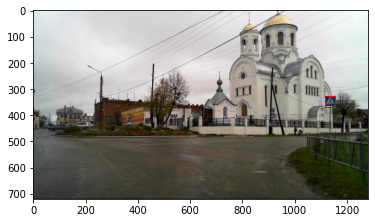

tensor([[173., 283., 204., 312.],
        [799., 306., 831., 338.]])
[173. 283. 204. 312.]
[799. 306. 831. 338.]


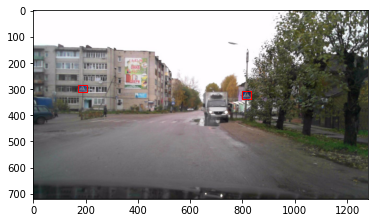

tensor([[639., 364., 658., 382.]])
[639. 364. 658. 382.]


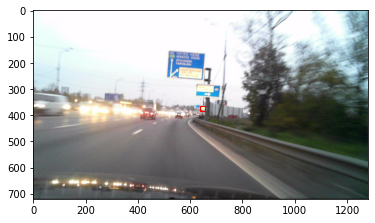

tensor([[1227.,  382., 1286.,  438.]])
[1227.  382. 1286.  438.]


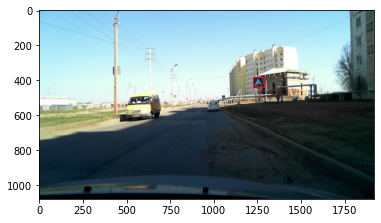

In [57]:
images, target = batch
plot_images_bb(batch) 

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
num_classes = 198
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/denis/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:16<00:00, 10.2MB/s]


AssertionError: Torch not compiled with CUDA enabled

In [6]:
num_epochs = 1
for epoch in range(num_epochs):
    loss_value = -1

    for index, (images, targets) in tqdm.tqdm(enumerate(train_loader)):
        images = [img.to(device) for img in images]
        targets = [trgt for trgt in targets]
        for trgt in targets:
            trgt['boxes'] = trgt['boxes'].to(device)
            trgt['labels'] = trgt['labels'].to(device)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if index % 100 == 0:
            print(f"Loss: {loss_value}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer.state_dict': optimizer.state_dict()
            }, 'models/rcnn_v1.pt')
            print("Saved model!")

        if index == 1000:
            break

    
    print(f"Loss: {loss_value}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer.state_dict': optimizer.state_dict()
    }, 'models/rcnn_v1.pt')
    

0it [00:00, ?it/s]Loss: 5.638509750366211
1it [00:02,  2.72s/it]Saved model!
100it [01:20,  1.26it/s]Loss: 0.4516942799091339
101it [01:22,  1.07s/it]Saved model!
200it [02:40,  1.25it/s]Loss: 0.5565142631530762
201it [02:42,  1.07s/it]Saved model!
300it [04:01,  1.25it/s]Loss: 0.2311491072177887
301it [04:02,  1.07s/it]Saved model!
400it [05:21,  1.25it/s]Loss: 0.5866162180900574
401it [05:23,  1.07s/it]Saved model!
500it [06:42,  1.25it/s]Loss: 0.3532553017139435
501it [06:44,  1.07s/it]Saved model!
600it [08:03,  1.25it/s]Loss: 0.3337276875972748
601it [08:04,  1.08s/it]Saved model!
700it [09:23,  1.24it/s]Loss: 0.06504780054092407
701it [09:25,  1.08s/it]Saved model!
800it [10:44,  1.24it/s]Loss: 0.27483877539634705
801it [10:46,  1.08s/it]Saved model!
900it [12:06,  1.24it/s]Loss: 0.23304757475852966
901it [12:07,  1.08s/it]Saved model!
1000it [13:27,  1.24it/s]Loss: 0.11639797687530518
1000it [13:28,  1.24it/s]Saved model!
Loss: 0.11639797687530518



In [5]:
def plot_images_bb(batch_pred, batch_true):
    images = batch_pred[0]
    targets_pred = batch_pred[1]
    targets_true = batch_true
    for ind, img in enumerate(images): 
        img = img.to("cpu")
        img = rearrange(img, 'c h w -> h w c')
        target_pred = targets_pred[ind]['boxes']
        target_true = targets_true[ind]['boxes']
        fig, ax = plt.subplots()
        ax.imshow(img)
        for box in target_pred:
            x0 = box[0]
            y0 = box[1]
            w = box[2] - x0
            h = box[3] - y0
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

        '''for box in target_true:
            x0 = box[0]
            y0 = box[1]
            w = box[2] - x0
            h = box[3] - y0
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='g', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)'''
        plt.show()

In [6]:
# [x0, y0, x1, y1]
def IoU(box0: list, box1: list):
    x0, y0 = max(box0[0], box1[0]), max(box0[1], box1[1])
    x1, y1 = min(box0[2], box1[2]), min(box0[3], box1[3])
    s0 = abs((box0[0] - box0[2]) * (box0[1] - box0[3]))
    s1 = abs((box1[0] - box1[2]) * (box1[1] - box1[3]))
    s_intersect = abs((x1 - x0) * (y1 - y0))
    return s_intersect / (s0 + s1 - s_intersect)

In [7]:
def intersect(batch, threshold_approve = 0.5, threshold_intersect = 0.3):
    images = batch[0]
    targets = batch[1]
    for ind in range(len(targets)): 
        bboxes = targets[ind]['boxes']
        labels = targets[ind]['labels']
        scores = targets[ind]['scores']
        
        boxes_res = list()
        labels_res = list()
        scores_res = list()

        for ind0 in range(len(bboxes)):
            winner = True
            for ind1 in range(ind0 + 1, len(bboxes)):
                box0 = bboxes[ind0].cpu().detach().numpy()
                box1 = bboxes[ind1].cpu().detach().numpy()
                label0 = labels[ind0]
                label1 = labels[ind1]
                score0 = scores[ind0]
                score1 = scores[ind1]
                if (score0 < threshold_approve) or (label0 == label1 and score0 < score1 and IoU(box0, box1) > threshold_intersect):
                    winner = False
                    break
            if winner:
                boxes_res.append(bboxes[ind0].cpu().detach().numpy())
                labels_res.append(labels[ind0].item())
                scores_res.append(scores[ind0].item())
        targets[ind]['boxes'] = boxes_res
        targets[ind]['labels'] = labels_res
        targets[ind]['scores'] = scores_res
        
    return [images, targets]

In [8]:
def get_recall(batch_pred, batch_true, threshold = 0.5):

    assert len(batch_pred) == len(batch_true)

    cnt_recall = 0.0
    for ind in range(len(batch_pred)):
        targets_pred, targets_true = batch_pred[ind], batch_true[ind]
        bboxes_pred, bboxes_true = targets_pred['boxes'], targets_true['boxes']
        labels_pred, labels_true = targets_pred['labels'], targets_true['labels']
        cnt_found = 0.0
        for ind_true, box_true in enumerate(bboxes_true):
            found = False
            for ind_pred, box_pred in enumerate(bboxes_pred):
                label_pred = labels_pred[ind_pred]
                label_true = labels_true[ind_true]
                if label_pred == label_true and IoU(box_pred, box_true) > threshold:
                    found = True
                    break
            if found:
                cnt_found += 1.0
        
        cnt_recall += cnt_found / len(bboxes_true)

    return cnt_recall / len(batch_true)


In [9]:
def get_precision(batch_pred, batch_true, threshold = 0.5):

    assert len(batch_pred) == len(batch_true)

    cnt_precision = 0.0
    for ind in range(len(batch_pred)):
        targets_pred, targets_true = batch_pred[ind], batch_true[ind]
        bboxes_pred, bboxes_true = targets_pred['boxes'], targets_true['boxes']
        labels_pred, labels_true = targets_pred['labels'], targets_true['labels']
        cnt_found = 0.0
        for ind_pred, box_pred in enumerate(bboxes_pred):
            found = False
            for ind_true, box_true in enumerate(bboxes_true):
                label_pred = labels_pred[ind_pred]
                label_true = labels_true[ind_true]
                if label_pred == label_true and IoU(box_pred, box_true) > threshold:
                    found = True
                    break
            if found:
                cnt_found += 1
        
        cnt_precision += cnt_found / len(bboxes_true)

    return cnt_precision / len(batch_true)

** Testing model **

In [5]:

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
num_classes = 198
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

checkpoint = torch.load('models/rcnn_v1.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer.state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"Loaded model's checkpoint! Start epoch = {start_epoch}")

Loaded model's checkpoint! Start epoch = 1


[{'boxes': [array([1037.5205 ,  191.87553, 1060.2219 ,  214.95833], dtype=float32), array([1059.0502 ,  159.23723, 1082.4652 ,  181.47908], dtype=float32)], 'labels': [23, 56], 'scores': [0.6023529171943665, 0.05254344642162323]}]
[{'boxes': tensor([[1037.,  190., 1061.,  215.]]), 'labels': tensor([23])}]


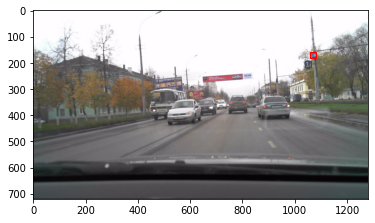

Recall = 1.0
Precision = 1.0
Recall = 1.0
Precision = 1.0


In [6]:
model.eval()
recall = 0
precision = 0
batches = 0
for index, (images, targets) in enumerate(test_loader):
    images = [img.to(device) for img in images]
    targets = [trgt for trgt in targets]
    for trgt in targets:
        trgt['boxes'] = trgt['boxes'].to(device)
        trgt['labels'] = trgt['labels'].to(device)
    bboxes = model(images)
    batch = [images]
    batch.append(bboxes)
    batch = intersect(batch)
    recall += get_recall(batch[1], targets)
    precision += get_precision(batch[1], targets)
    batches += 1

    print(batch[1])
    print(targets)
    plot_images_bb(batch, targets)
    if index % 1 == 0:
        print(f'Recall = {recall / batches}')
        print(f'Precision = {precision / batches}')
    break

recall /= batches
precision /= batches
print(f'Recall = {recall}')
print(f'Precision = {precision}')